# SARFish Vessel Length Regressor

## 1. Setup

In [7]:
# Better error messages in notebooks
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Set up data paths
from pathlib import Path
import sys

# Get to project root from notebook location
PROJECT_ROOT = Path.cwd().parent.parent
# Add "src" to Python's module search path sys.path
sys.path.append(str(PROJECT_ROOT / "modelling" /"src"))
# Add "working" to Python's module search path sys.path
sys.path.append(str(PROJECT_ROOT / "working"))

# Define project paths
DATA_DIR = Path("/mnt/h/SARFish/Generated/SLC/")
RUNS_DIR = PROJECT_ROOT / "modelling" / "runs"
WORK_DIR = PROJECT_ROOT / "working"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR:     {DATA_DIR}")
print(f"RUNS_DIR:     {RUNS_DIR}")
print(f"WORK_DIR:     {WORK_DIR}")

PROJECT_ROOT: /home/peterm/UWA/CITS5014/SARFish
DATA_DIR:     /mnt/h/SARFish/Generated/SLC
RUNS_DIR:     /home/peterm/UWA/CITS5014/SARFish/modelling/runs
WORK_DIR:     /home/peterm/UWA/CITS5014/SARFish/working


In [42]:
import numpy as np
import pandas as pd
import cv2
import glob as glob
import yaml
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
from ultralytics import YOLO

import tensorflow as tf
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from utilities import *
from plot_loss_curves import plot_total_loss
from du_utilities import *

from label_feature_extractor import extract_features_from_labels
from extract_bbox_features import extract_bbox_features
from rf_vlen_regressor import  VesselLengthRegressor
from match_png_vessel_lengths import build_image_vessel_length_table

from run_inference_and_export import run_inference_and_save_results
from crops_analyser import analyse_crops

## 2. Data preparation

Training and validation input files for vessel regression are constructed using the ground truth label files created during the image cropping process. For inference, the input file should be generated from the bounding box predictions output by the vessel detector. 

Procedure:

A. Training and validation splits

For both splits, construct an input file containing ground truth information for every detection in that split. Each row of the table should include a label filename,  ground truth bounding box dimensions (width and height) and class. Appended to each row should be the corresponding vessel length in metres.

B. Test set.

The structure of the input file used for inference should be identical with the following two exceptions:
•	Label filenames are substituted with the test set image filenames.
•	The bounding box dimensions and class Ids should bebe generated by the vessel detector


**Note:** The feature extraction process extracts the box width and height 'as is', i.e., in normalised coordinates \[0, 1\]. Width and height in pixel units are optionally added later. The ground truth vessel lengths are also 'as is' (no scaling applied).

### 2.1. `train` set

Extract features for vessel length regressor training.

In [7]:
# Assemble the ground truth features for the regressor training set 
train_features_df = extract_features_from_labels(
                        metadata_csv_path =  WORK_DIR / 'df_labels_train_filt.csv',
                        label_dir =          WORK_DIR / 'train' / 'crops_raw' / 'labels',
                        output_csv_path =    WORK_DIR / 'train_vlen_reg_input.csv',
                        matching_logfile =   WORK_DIR / 'train_matching.log',
                        extraction_logfile = WORK_DIR / 'train_feature_extraction.log')

Step 1: Matching label files with vessel lengths...
Step 1 completed: 3092 files matched

Step 2: Extracting features from label files...


Processing label files: 100%|███████████████████████████████████████████████████████| 3092/3092 [01:45<00:00, 29.36it/s]

Step 2 completed: 3092 feature records extracted


In [8]:
# Print basic stats for the lookup table just created
train_vlen_reg_input_summary = summarise_csv(WORK_DIR / 'train_vlen_reg_input.csv')
print(train_vlen_reg_input_summary)

                   dtype  count  missing       min         max
class              int64   3092        0  0.000000    1.000000
height           float64   3092        0  0.010417    0.552083
label_filename    object   3092        0       NaN         NaN
vessel_length_m  float64   3092        0  6.960000  343.400000
width            float64   3092        0  0.052083    1.000000


In [9]:
# Optionally add un-normlised width and height columns ('width_pixels' and 'height_pixels')
#df = unnormalize_features(WORK_DIR / 'train_vlen_reg_input.csv')

Unnormalized features saved to /home/peterm/UWA/CITS5014/SARFish/working/train_vlen_reg_input.csv
Added columns: width_pixels, height_pixels (crop_size=96)


### 2.2 `val` set

Repeat feature extraction for the `val` set in the same way as for `train`

In [10]:
# Assemble the ground truth features for the regressor validation set 
val_features_df = extract_features_from_labels(
                        metadata_csv_path =  WORK_DIR /  'df_labels_val_filt.csv',
                        label_dir =          WORK_DIR /  'val' / 'crops_raw' / 'labels',
                        output_csv_path =    WORK_DIR /  'val_vlen_reg_input.csv',
                        matching_logfile =   WORK_DIR /  'val_matching.log',
                        extraction_logfile = WORK_DIR /  'val_feature_extraction.log')

Step 1: Matching label files with vessel lengths...
Step 1 completed: 459 files matched

Step 2: Extracting features from label files...


Processing label files: 100%|████████████████████████████████████████████████████████| 459/459 [00:03<00:00, 122.06it/s]

Step 2 completed: 459 feature records extracted


In [11]:
# Print basic stats for the lookup table just created
val_vlen_reg_input_summary = summarise_csv(WORK_DIR / 'val_vlen_reg_input.csv')
print(val_vlen_reg_input_summary)

                   dtype  count  missing       min         max
class              int64    459        0  0.000000    1.000000
height           float64    459        0  0.010417    0.604167
label_filename    object    459        0       NaN         NaN
vessel_length_m  float64    459        0  9.990000  240.168797
width            float64    459        0  0.052083    1.000000


In [12]:
# Add un-normlised width and height columns ('width_pixels' and 'height_pixels')
#df = unnormalize_features(WORK_DIR / 'val_vlen_reg_input.csv')

Unnormalized features saved to /home/peterm/UWA/CITS5014/SARFish/working/val_vlen_reg_input.csv
Added columns: width_pixels, height_pixels (crop_size=96)


### 2.3 `test` set

The `test` set is treated differently. The extracted bounding box features (w, h, cls) are extracted from the predicted bounding boxes output by the **vessel detector**. These predicted features are then matched with the corresponding ground truth vessel lengths to be referenced later at inference time.

In [52]:
# First build a look-up file matching vessel image png file with corresponding ground truth vessel length
build_image_vessel_length_table(input_csv_path =   WORK_DIR / 'df_labels_test_filt.csv',
                                png_dir =          DATA_DIR / 'test' / 'crops_png_alt' / 'images',
                                output_csv_path =  WORK_DIR / 'test_png_vlen.csv', 
                                logfile =          WORK_DIR / 'test_matching.log',
                                return_data = False)

Loaded 254 records from CSV
Created lookup dictionary with 254 entries
Found 253 .png files
Successfully matched 248/248 files
Files with NaN vessel lengths: 0
Unparsed files: 0
Skipped mosaic files: 0
Output saved to /home/peterm/UWA/CITS5014/SARFish/working/test_png_vlen.csv


In [14]:
from match_png_vessel_lengths import build_image_vessel_length_table

# First build a look file matching vessel image png file with corresponding ground truth vessel length
build_image_vessel_length_table(input_csv_path =   WORK_DIR / 'df_labels_test_filt.csv',
                                png_dir =          DATA_DIR / 'test' / 'crops_png_dual' / 'images',
                                output_csv_path =  WORK_DIR / 'test_png_vlen.csv', 
                                logfile =          WORK_DIR / 'test_matching.log',
                                return_data = False)

Loaded 254 records from CSV
Created lookup dictionary with 254 entries
Found 253 .png files
Successfully matched 248/248 files
Files with NaN vessel lengths: 0
Unparsed files: 0
Skipped mosaic files: 0
Output saved to /home/peterm/UWA/CITS5014/SARFish/working/test_png_vlen.csv


In [10]:
# Build the path the saved vessel detector model - latest best model ('dual-polarisation')
model_path = RUNS_DIR / 'png_runs' / 'png_aug_dual' / '20250915_1358_30042' / 'weights' / 'best.pt'

#### Note: the predictions below are made with parameters conf=0.03, iou=0.3

In [11]:
# Now extract predict bounding box features and assemble dataset inference for input into vessel length regressor
extract_bbox_features(model_path=model_path,
                      metadata_path = WORK_DIR / 'test_png_vlen.csv',
                      image_dir     = DATA_DIR / 'test' / 'crops_png_dual' / 'images',
                      file_ext      = '.png',
                      output_csv    = WORK_DIR / 'test_vlen_reg_input.csv',
                      logfile       = WORK_DIR / 'extract_bbox_features.log')

Loaded metadata with 248 records
Created lookup dictionary with 248 entries
Found 253 image files with extension .png


Processing images: 100%|██████████████████████████████████████████████████████████████| 253/253 [00:08<00:00, 28.33it/s]


=== PROCESSING SUMMARY ===
Total images found: 253
Images processed: 253
Skipped - no metadata: 5
Skipped - invalid vessel length: 0
Skipped - no detections: 48
Total detections found: 208
Records created: 208
Saved 208 records to /home/peterm/UWA/CITS5014/SARFish/working/test_vlen_reg_input.csv


Comment: the model.predict() method is hardcoded to use YOLO defaults. Consider changing some of the parameters, e.g. conf (detection confidence threshhold) or IoU (threshold for NMS)

**Note:** 237 detections out of 253 ground truth labels (248 of which actuall have a vessel length), using conf=0.04 and iou=0.65.

In [12]:
# Print basic stats for the lookup table just created
test_vlen_reg_input_summary = summarise_csv(WORK_DIR / 'test_vlen_reg_input.csv')
print(test_vlen_reg_input_summary)

                   dtype  count  missing        min         max
class              int64    208        0   0.000000    1.000000
conf             float64    208        0   0.030069    0.347544
height           float64    208        0   0.034449    0.284690
image             object    208        0        NaN         NaN
vessel_length_m  float64    208        0  13.369143  274.397788
width            float64    208        0   0.083744    0.908943


In [13]:
# Optionally add un-normlised width and height columns ('width_pixels' and 'height_pixels')
#df = unnormalize_features(WORK_DIR / 'test_vlen_reg_input.csv')

Unnormalized features saved to /home/peterm/UWA/CITS5014/SARFish/working/test_vlen_reg_input.csv
Added columns: width_pixels, height_pixels (crop_size=96)


## 3. Vessel Length Regression

### 3.1 RandomForestRegressor

Use the "features" extracted from the train, val and test sets as inputs to train a RandomForest Regressor.

In [30]:
# Instantiate a regressor with the best parameter values determined with the aid of randomized search
regressor = VesselLengthRegressor(model_params={'max_depth': 10, 
                                                'min_samples_leaf': 5, 
                                                'min_samples_split': 2, 
                                                'n_estimators': 413,
                                                'n_jobs': 1,
                                                'random_state': 42}, 
                                  feature_cols=['width', 'height', 'class'],
                                  sample_weights={0: 1.0, 1: 1.0}) # no sample weight bias applied

In [31]:
# Load and prepare the data

train_csv = WORK_DIR / 'train_vlen_reg_input.csv'  # based on ground truth
val_csv   = WORK_DIR / 'val_vlen_reg_input.csv'    # based on grount truth (not used for rf regressor)
test_csv  = WORK_DIR / 'test_vlen_reg_input.csv'   # based on vessel detection model predicted bboxes

X_train, y_train, X_val, y_val, X_test, y_test = regressor.load_and_prepare_data(train_csv, val_csv, test_csv)

In [32]:
X_train

array([[    0.35417,      0.0625,           0],
       [    0.33333,     0.13542,           0],
       [    0.51042,       0.125,           0],
       ...,
       [     0.1875,    0.052083,           1],
       [    0.23958,     0.09375,           1],
       [    0.10417,     0.03125,           1]])

- The following swaps 'width' and 'height' values where width > height (all splits). The resulting variables should be called short dimension, long dimension. 

- An important assumption is that vessels are longer than they are wide.

In [33]:
# Create a mask for rows where column 0 > column 1
mask = X_train[:, 0] > X_train[:, 1]

# Swap column 0 and 1 for those rows
X_train[mask] = X_train[mask][:, [1, 0, 2]]

In [34]:
X_train

array([[     0.0625,     0.35417,           0],
       [    0.13542,     0.33333,           0],
       [      0.125,     0.51042,           0],
       ...,
       [   0.052083,      0.1875,           1],
       [    0.09375,     0.23958,           1],
       [    0.03125,     0.10417,           1]])

In [35]:
# Create a mask for rows where column 0 > column 1
mask = X_val[:, 0] > X_val[:, 1]

# Swap column 0 and 1 for those rows
X_val[mask] = X_val[mask][:, [1, 0, 2]]

In [36]:
# Create a mask for rows where column 0 > column 1
mask = X_test[:, 0] > X_test[:, 1]

# Swap column 0 and 1 for those rows
X_test[mask] = X_test[mask][:, [1, 0, 2]]

```python
def convert_to_greens(y, minval, maxval):
    # convert to uint8 in the range 0..255
    arr = np.uint8((y - minval)/(maxval - minval)*255)
    # return as a list of rgb (in hexidecimal) colour strings
    return ['#00' + np.base_repr(a, 16).lower().zfill(2) + '00' for a in arr]

minval = np.min(np.r_[y_train,y_val,y_test])
maxval = np.max(np.r_[y_train,y_val,y_test])
y_train = convert_to_greens(y_train, minval, maxval)
y_val = convert_to_greens(y_val, minval, maxval)
y_test = convert_to_greens(y_test, minval, maxval)
```

```python
_,axes = plt.subplots(3, 2, figsize=(10,12), sharex=True)
print('Dark green: short vessel length; Bright green: long vessel length')
for row,X,y,name in zip(range(3),[X_train,X_val,X_test],[y_train,y_val,y_test],['Train','Val','Test']):
    for c in range(2):
            indices = np.where(X[:,-1] == c)[0]
            for id in indices:
                axes[row,c].plot(X[id,0], X[id,1], color=y[id], marker='o', alpha=0.3)
            if row == 2:
                axes[row,c].set_xlabel('Feature 0')
            if c == 0:
                axes[row,c].set_ylabel('Feature 1')
            axes[row,c].axis('equal')
            axes[row,c].grid('on')
            axes[row,c].set_title(f'{name:s}: class {c:d} ({len(indices):,d} instances)')
            axes[row,c].set_ylim(0, 0.8)
plt.show()
```

In [37]:
# Check shape and range of each data split
print(f"X_train: {np.shape(X_train), np.min(X_train, axis=0), np.max(X_train, axis=0)}, y_train: {np.shape(y_train), np.min(y_train), np.max(y_train)}")
print(f"X_val:   {np.shape(X_val), np.min(X_val, axis=0), np.max(X_val, axis=0)},  y_val: {np.shape(y_val),np.min(y_val), np.max(y_val)}")
print(f"X_test:  {np.shape(X_test), np.min(X_test, axis=0), np.max(X_test, axis=0)},  y_test: {np.shape(y_test),np.min(y_test), np.max(y_test)}")

X_train: ((3092, 3), array([   0.010417,    0.052083,           0]), array([    0.55208,           1,           1])), y_train: ((3092,), 6.96, 343.4)
X_val:   ((459, 3), array([   0.010417,    0.052083,           0]), array([    0.60417,           1,           1])),  y_val: ((459,), 9.99, 240.1687969)
X_test:  ((208, 3), array([   0.034449,    0.083744,           0]), array([    0.28469,     0.90894,           1])),  y_test: ((208,), 13.36914283, 274.3977876)


In [51]:
#picklesave((X_train, y_train, X_val, y_val, X_test, y_test), str('/home/peterm/CITS5014/SARFish/modelling/data/mlp_regressor_unnorm.pkl'))
picklesave((X_train, y_train, X_val, y_val, X_test, y_test), str('/home/peterm/UWA/CITS5014/SARFish/modelling/runs/vlength/rf/20251002_0935/mlp_regressor_unnorm.pkl'))

```python
# Perform a randomized search for the best parameter values for the nominated parameters

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 20)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

rf = RandomForestRegressor()
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, cv=5, n_iter=10, random_state=None)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
```

The optimal values for the four parameters were arrived at using the randomized search above and subsequent manual fine-tuning . They are:
- `max_depth`: 10,
- `min_samples_leaf`: 5,
- `min_samples_split`: 2
- `n_estimators`: 413

In [39]:
# Train the regressor
model = regressor.train_regressor(X_train, y_train)
print("Model training completed!")
print(f"Feature importances: { {col: f'{imp:.3f}' for col, imp in zip(regressor.feature_cols, model.feature_importances_)} }")

Model training completed!
Feature importances: {'width': '0.084', 'height': '0.814', 'class': '0.102'}


In [59]:
import joblib

# Load the saved .pkl model
#model = joblib.load('../runs/vlength/rf/20250910_0956/rf_no_aug_biased.pkl')

In [40]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [43]:
# Calculate and display metrics for each split
if 'class' in regressor.feature_cols:
    class_idx = regressor.feature_cols.index('class')
    train_metrics = regressor.calculate_metrics_by_class(y_train, y_train_pred, X_train[:, class_idx], "Training")
    test_metrics = regressor.calculate_metrics_by_class(y_test, y_test_pred, X_test[:, class_idx], "Test")


=== Training Metrics ===
Overall      MAE:  21.18, R²:  0.721, VLA:  0.631
is_vessel    MAE:  25.98, R²:  0.618, VLA:  0.603 (n=2323)
is_fishing   MAE:   6.69, R²:  0.485, VLA:  0.715 (n=769)

=== Test Metrics ===
Overall      MAE:  20.63, R²:  0.735, VLA:  0.606
is_vessel    MAE:  24.73, R²:  0.648, VLA:  0.571 (n=155)
is_fishing   MAE:   8.64, R²: -0.072, VLA:  0.708 (n=53)


Save the model (if required):

In [44]:
# Generate timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Define log directory and save path
log_dir=f"/home/peterm/UWA/CITS5014/SARFish/modelling/runs/vlength/rf/{timestamp}"
save_path = 'rf_no_aug_biased.pkl'

# Save the model
model_save_path = regressor.save_model(save_path, log_dir)

Regressor saved to /home/peterm/UWA/CITS5014/SARFish/modelling/runs/vlength/rf/20251002_0935/rf_no_aug_biased.pkl


Plot the results: predicted versus true vessel length plots for each split.

Plot saved to /home/peterm/UWA/CITS5014/SARFish/modelling/runs/vlength/rf/20251002_0935/rf_vlen_results_20251002_0935.pdf


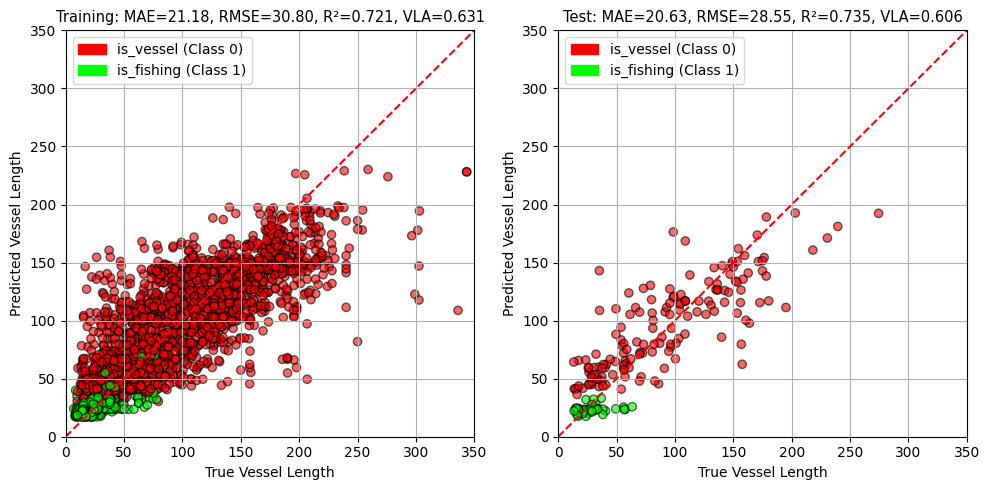

In [47]:
# Extract class information for colored plotting (if 'class' is in features)
train_classes = X_train[:, regressor.feature_cols.index('class')] if 'class' in regressor.feature_cols else None
val_classes = X_val[:, regressor.feature_cols.index('class')] if 'class' in regressor.feature_cols else None
test_classes = X_test[:, regressor.feature_cols.index('class')] if 'class' in regressor.feature_cols else None

# Prepare plot data dictionary
plot_data = {
    'train_true': y_train, 'train_pred': y_train_pred,
    'test_true': y_test, 'test_pred': y_test_pred,
    'train_metrics': train_metrics['overall'],  
    'test_metrics': test_metrics['overall'], 
    'train_classes': train_classes,
    'test_classes': test_classes
  }
# Generate all plots
regressor.plot_results(plot_data, save_path='rf_vlen_results_20251002_0935.pdf', log_dir=f"/home/peterm/UWA/CITS5014/SARFish/modelling/runs/vlength/rf/20251002_0935")

### 3.2 MLP regressor

In [71]:
from mlp_vessel_regressor import *

# Reset the name counters
tf.keras.backend.clear_session()

In [79]:
# Create model architecture
model = create_mlp_model(input_dim=3, hidden_layers=[32, 16, 8])

In [80]:
# Display model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Setup target (vessel length) scaling
y_scaler, y_train_scaled = setup_target_scaler(y_train)
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()

In [82]:
# Create custom loss function - Absolute Relative Error (scaled)
loss_function = create_custom_loss(y_scaler)

In [83]:
# Compile with custom ARE loss and SGD optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.00025, momentum=0.9, nesterov=True)
model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae'])

In [84]:
# Setup VLA and model checkpoint callbacks
checkpoint_path = '../models/mlp/best_model.keras'
callbacks = create_callbacks(checkpoint_path, X_val, y_val, y_scaler, vla_freq=5)

In [85]:
# Train model
tf.random.set_seed(42)
    
history = model.fit(
    X_train, y_train_scaled,
    batch_size=32,
    epochs=120,
    shuffle=True,
    validation_data=(X_val, y_val_scaled),
    callbacks=callbacks,
    verbose=0
)

I0000 00:00:1757556852.803607 1853167 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1 - Validation VLA: 0.639

Epoch 6 - Validation VLA: 0.671

Epoch 11 - Validation VLA: 0.673

Epoch 16 - Validation VLA: 0.667

Epoch 21 - Validation VLA: 0.671

Epoch 26 - Validation VLA: 0.666

Epoch 31 - Validation VLA: 0.668

Epoch 36 - Validation VLA: 0.668

Epoch 41 - Validation VLA: 0.668

Epoch 46 - Validation VLA: 0.666

Epoch 51 - Validation VLA: 0.669

Epoch 56 - Validation VLA: 0.670

Epoch 61 - Validation VLA: 0.665

Epoch 66 - Validation VLA: 0.665

Epoch 71 - Validation VLA: 0.662

Epoch 76 - Validation VLA: 0.672

Epoch 81 - Validation VLA: 0.666

Epoch 86 - Validation VLA: 0.666

Epoch 91 - Validation VLA: 0.670

Epoch 96 - Validation VLA: 0.665

Epoch 101 - Validation VLA: 0.670

Epoch 106 - Validation VLA: 0.660

Epoch 111 - Validation VLA: 0.664

Epoch 116 - Validation VLA: 0.664


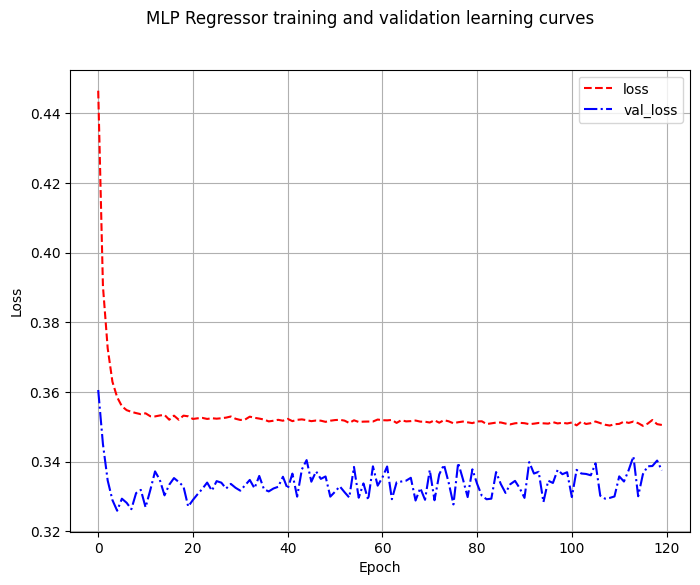

In [86]:
# Plot learning curves
fig = plot_learning_curves(history, title="MLP Regressor training and validation learning curves", figsize=(8, 6))

In [17]:
# Load best model (after training)
best_model = load_mlp_model(checkpoint_path, y_scaler)

Complete model loaded from ../models/mlp/best_model.keras


In [18]:
# Save figure if required
save_fig("../models/mlp/mlp_loss_(4_32-16-8_lr25e-5)", fig=fig)

Figure saved as: ../models/mlp/mlp_loss_(4_32-16-8_lr25e-5).pdf


In [19]:
y_train_pred = make_predictions(best_model, X_train, y_scaler)
y_val_pred = make_predictions(best_model, X_val, y_scaler)
y_test_pred = make_predictions(best_model, X_test, y_scaler)

In [20]:
# Calculate and display metrics for each split
train_mlp_metrics = calculate_metrics_by_class(y_train, y_train_pred, X_train[:, -1], "Training")
val_mlp_metrics = calculate_metrics_by_class(y_val, y_val_pred, X_val[:, -1], "Validation")
test_mlp_metrics = calculate_metrics_by_class(y_test, y_test_pred, X_test[:, -1], "Test")


=== Training Metrics ===
Overall      MAE:  17.24, RMSE:  29.69, R²:  0.697, VLA:  0.694
is_vessel    MAE:  31.68, RMSE:  44.51, R²:  0.353, VLA:  0.666 (n=2863)
is_fishing   MAE:   8.39, RMSE:  14.44, R²:  0.129, VLA:  0.712 (n=4673)

=== Validation Metrics ===
Overall      MAE:  24.73, RMSE:  34.33, R²:  0.627, VLA:  0.698
is_vessel    MAE:  30.25, RMSE:  39.29, R²:  0.412, VLA:  0.699 (n=219)
is_fishing   MAE:   9.01, RMSE:  11.84, R²: -0.075, VLA:  0.693 (n=77)

=== Test Metrics ===
Overall      MAE:  29.54, RMSE:  41.75, R²:  0.486, VLA:  0.621
is_vessel    MAE:  32.83, RMSE:  44.58, R²:  0.350, VLA:  0.608 (n=168)
is_fishing   MAE:   7.45, RMSE:   9.78, R²:  0.185, VLA:  0.710 (n=25)


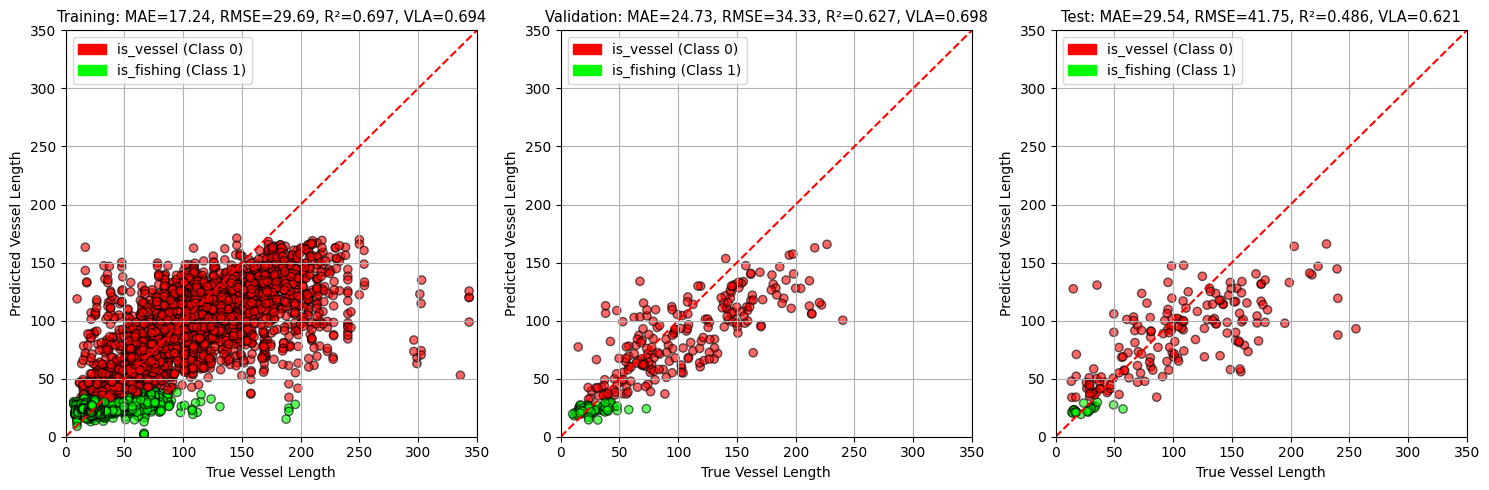

In [21]:
# Display predictded versus true vessel length plots for each split (use the rf regressor plot function)

# Create a temporary RF regressor instance just for plotting
temp_regressor = VesselLengthRegressor()

# Prepare plot data dictionary - extract 'overall' metrics
plot_data = {
    'train_true': y_train, 'train_pred': y_train_pred,
    'val_true': y_val, 'val_pred': y_val_pred,
    'test_true': y_test, 'test_pred': y_test_pred,
    'train_metrics': train_mlp_metrics['overall'],
    'val_metrics': val_mlp_metrics['overall'],
    'test_metrics': test_mlp_metrics['overall'],
    'train_classes': X_train[:, -1],
    'val_classes': X_val[:, -1],
    'test_classes': X_test[:, -1]
}

# Generate all three plots side by side
temp_regressor.plot_results(plot_data)

### 3.3 CNN regressor

#### 3.3.1 Data preparation

First generate predictions on training data and export and save image sub-crops based on the predicted bounding boxes. Analyse the sub-crops to determine an optimal size to re-size all the sub-crops, then resize them.

In [115]:
# Generate training prediction subcrops
run_inference_and_save_results(
     model_path=model_path,
     test_images_dir="/mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal",
     output_dir="/mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds",
     conf_threshold=0.25,
     iou_threshold=0.7
)

Found 8396 images to process


Processing images: 100%|███████████████████████████████████████████████████████████| 8396/8396 [44:35<00:00,  3.14img/s]


Inference completed!
Results saved to: /mnt/h/SARFish/Generated/SLC/test/crops_png_alt/images_hvrt_msc_bal_preds/detection_results.txt
Cropped images saved to: /mnt/h/SARFish/Generated/SLC/test/crops_png_alt/images_hvrt_msc_bal_preds/crops
Total images processed: 8396


In [119]:
# Analyse the subcrop dimensions
analyse_crops("/mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds/crops")

Analyzing crops in: /mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds/crops
Directory exists: ✓
Found 7693 image files
First few files:
  - 0d8ed29b0760dc59v_043.21094381000000339554_015.15049506000000079098_swath1_aug0_vflip_translate_proc_is_vessel_0_conf0.567.png
  - 0d8ed29b0760dc59v_043.21094381000000339554_015.15049506000000079098_swath1_original_proc_is_vessel_0_conf0.443.png
  - 0d8ed29b0760dc59v_043.22273045000000024629_014.93491904999999952963_swath1_aug0_hflip_rotate_proc_is_vessel_0_conf0.287.png
  - 0d8ed29b0760dc59v_043.22273045000000024629_014.93491904999999952963_swath1_original_proc_is_vessel_0_conf0.577.png
  - 0d8ed29b0760dc59v_043.28511705999999747974_014.51577484000000062281_swath1_original_proc_is_vessel_0_conf0.684.png

Analyzing dimensions...
  0d8ed29b0760dc59v_043.21094381000000339554_015.15049506000000079098_swath1_aug0_vflip_translate_proc_is_vessel_0_conf0.567.png: 50 x 14
  0d8ed29b0760dc59v_043.21094381000000339554_015.15049506000

In [54]:
# Resize images to 64 x 64 pixels (minimal upscaling)
!python ../src/resize_crops.py --crops "/mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds/crops" \
                        --output "/mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds_rsz24/crops" \
                        --size 24 24 --preserve-aspect

Resizing crops from: /mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds/crops
Output directory: /mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds_rsz24/crops
Target size: 24 x 24
Interpolation: bilinear
Mode: Aspect ratio preserving with padding color (0, 0, 0)
Resizing 7693 images to 24x24 with aspect ratio preservation...
Using bilinear interpolation with padding color: (0, 0, 0)
Resizing with aspect preservation: 100%|███| 7693/7693 [21:35<00:00,  5.94img/s]
Resizing complete! Images saved to: /mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds_rsz24/crops
